# Install Libraries

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
! pip uninstall opencv-python
! pip install opencv-python==4.5.2.54

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ou4fkcnk
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ou4fkcnk
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112538 sha256=1e85bbd01e88be2e3e95418084fe3e370ecca4afb6ddc2e8442c6ba03f073394
  Stored in directory: /tmp/pip-ephem-wheel-cache-jvtfsssa/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
  Would not remove

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision.datasets.vision import VisionDataset
from torchvision import transforms
import pathlib
from copy import deepcopy
import cv2
import albumentations as albu
import matplotlib.pyplot as plt
import time
import copy

# Define Paths

In [ ]:
data_dir = '/content/drive/My Drive/Remote Sensing Image Analysis/assignment2/report2/data/'
model_dir = '/content/drive/My Drive/Remote Sensing Image Analysis/assignment2/report2/model/'
pred_dir = '/content/drive/My Drive/Remote Sensing Image Analysis/assignment2/report2/result/'

x_train_dir = os.path.join(data_dir, 'train_img')
y_train_dir = os.path.join(data_dir, 'train_label')

x_val_dir = os.path.join(data_dir, 'val_img')
y_val_dir = os.path.join(data_dir, 'val_label')

# Define Configurations

In [ ]:
batch_size = 8
epochs = 60
img_size = 256
in_ch = 3 # number of input channels (RGB)
out_ch = 1 # number of output channels (1 for binary classification)
prediction_threshold = 0.5
model_name = 'macunet'
model_file = "%s_E%d_B%d.pth"%(model_name, epochs, batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Dataset Class

In [ ]:
# Reference: https://github.com/qubvel/segmentation_models.pytorch

class SemanticSegmentationDataset(VisionDataset):
    CLASSES = [
        "nonbuilding",
        "building",
    ]

    def __init__(
        self,
        images_dir,
        masks_dir,
        classes=None,
        augmentation=None,
    ):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.rgb_list = self._get_rgb_list()

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation

    def _get_rgb_list(self):
        return list(sorted(pathlib.Path(self.images_dir).glob("*.png")))

    def __len__(self):
        return len(self.rgb_list)

    def __getitem__(self, index):
        rgb_path = self.rgb_list[index]
        rgb_fname = rgb_path.stem
        cls_path = os.path.join(self.masks_dir, rgb_fname + '.png')

        #image = imread(str(rgb_path))
        image = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)

        #mask = imread(str(cls_path))
        mask = cv2.imread(str(cls_path), cv2.IMREAD_UNCHANGED)
        mask[mask < 255] = 0  # non-buildings
        mask[mask == 255] = 1  # buildings
        mask = mask.astype('int64')

        # extract certain classes from mask (e.g. building)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('int64')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask, str(rgb_path)

# Define Augmentation Helper Functions

In [ ]:
# Reference: https://github.com/albumentations-team/albumentations

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def to_tensor_labels(x, **kwargs):
    return x.transpose(2, 0, 1).astype('int64')

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.RandomCrop(height=img_size, width=img_size, p=0.5),
        albu.Resize(img_size,img_size),
        albu.Lambda(image=to_tensor,mask=to_tensor)
    ]

    return albu.Compose(train_transform)

def get_val_augmentation():
    test_transform = [
        albu.Resize(img_size,img_size),
        albu.Lambda(image=to_tensor,mask=to_tensor)
    ]

    return albu.Compose(test_transform)

def get_IoU(pred_mask, mask, eps=1e-10):
    iou = None

    with torch.no_grad():
        intersection = torch.sum(mask * pred_mask)
        union = torch.sum(mask) + torch.sum(pred_mask) - intersection + eps
        iou = (intersection + eps) / union

    return iou

# Define Model Class

In [ ]:
# Reference: https://github.com/lironui/MACU-Net/blob/master/MACUNet.py

import torch
from torch import nn


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, out_planes, ratio=2):
        super(ChannelAttention, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, 1, bias=False)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc11 = nn.Conv2d(out_planes, out_planes // ratio, 1, bias=False)
        self.fc12 = nn.Conv2d(out_planes // ratio, out_planes, 1, bias=False)

        self.fc21 = nn.Conv2d(out_planes, out_planes // ratio, 1, bias=False)
        self.fc22 = nn.Conv2d(out_planes // ratio, out_planes, 1, bias=False)
        self.relu1 = nn.ReLU(True)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        avg_out = self.fc12(self.relu1(self.fc11(self.avg_pool(x))))
        max_out = self.fc22(self.relu1(self.fc21(self.max_pool(x))))
        out = avg_out + max_out
        del avg_out, max_out
        return x * self.sigmoid(out)


def conv3otherRelu(in_planes, out_planes, kernel_size=None, stride=None, padding=None):
    # 3x3 convolution with padding and relu
    if kernel_size is None:
        kernel_size = 3
    assert isinstance(kernel_size, (int, tuple)), 'kernel_size is not in (int, tuple)!'

    if stride is None:
        stride = 1
    assert isinstance(stride, (int, tuple)), 'stride is not in (int, tuple)!'

    if padding is None:
        padding = 1
    assert isinstance(padding, (int, tuple)), 'padding is not in (int, tuple)!'

    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
        # nn.ReLU()  # inplace=True
        nn.LeakyReLU()
    )


class ACBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(ACBlock, self).__init__()
        self.squre = nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=1, stride=1)
        self.cross_ver = nn.Conv2d(in_planes, out_planes, kernel_size=(1, 3), padding=(0, 1), stride=1)
        self.cross_hor = nn.Conv2d(in_planes, out_planes, kernel_size=(3, 1), padding=(1, 0), stride=1)
        self.bn = nn.BatchNorm2d(out_planes)
        self.ReLU = nn.ReLU(True)

    def forward(self, x):
        x1 = self.squre(x)
        x2 = self.cross_ver(x)
        x3 = self.cross_hor(x)
        return self.ReLU(self.bn(x1 + x2 + x3))


class MACUNet(nn.Module):
    def __init__(self, band_num, class_num):
        super(MACUNet, self).__init__()
        self.band_num = band_num
        self.class_num = class_num
        self.name = 'MACUNet'

        # channels = [32, 64, 128, 256, 512]
        channels = [16, 32, 64, 128, 256, 512]
        self.conv1 = nn.Sequential(
            ACBlock(self.band_num, channels[0]),
            ACBlock(channels[0], channels[0])
        )
        self.conv12 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[0], channels[1])
        )
        self.conv13 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[1], channels[2]),
        )
        self.conv14 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[2], channels[3])
        )

        self.conv2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[0], channels[1]),
            ACBlock(channels[1], channels[1])
        )
        self.conv23 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[1], channels[2])
        )
        self.conv24 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[2], channels[3])
        )

        self.conv3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[1], channels[2]),
            ACBlock(channels[2], channels[2]),
            ACBlock(channels[2], channels[2])
        )
        self.conv34 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[2], channels[3])
        )

        self.conv4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[2], channels[3]),
            ACBlock(channels[3], channels[3]),
            ACBlock(channels[3], channels[3])
        )

        self.conv5 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ACBlock(channels[3], channels[4]),
            ACBlock(channels[4], channels[4]),
            ACBlock(channels[4], channels[4])
        )

        self.skblock4 = ChannelAttention(channels[3]*5, channels[3]*2, 16)
        self.skblock3 = ChannelAttention(channels[2]*5, channels[2]*2, 16)
        self.skblock2 = ChannelAttention(channels[1]*5, channels[1]*2, 16)
        self.skblock1 = ChannelAttention(channels[0]*5, channels[0]*2, 16)

        self.deconv4 = nn.ConvTranspose2d(channels[4], channels[3], kernel_size=(2, 2), stride=(2, 2))
        self.deconv43 = nn.ConvTranspose2d(channels[3], channels[2], kernel_size=(2, 2), stride=(2, 2))
        self.deconv42 = nn.ConvTranspose2d(channels[2], channels[1], kernel_size=(2, 2), stride=(2, 2))
        self.deconv41 = nn.ConvTranspose2d(channels[1], channels[0], kernel_size=(2, 2), stride=(2, 2))

        self.conv6 = nn.Sequential(
            ACBlock(channels[4], channels[3]),
            ACBlock(channels[3], channels[3]),
        )

        self.deconv3 = nn.ConvTranspose2d(channels[3], channels[2], kernel_size=(2, 2), stride=(2, 2))
        self.deconv32 = nn.ConvTranspose2d(channels[2], channels[1], kernel_size=(2, 2), stride=(2, 2))
        self.deconv31 = nn.ConvTranspose2d(channels[1], channels[0], kernel_size=(2, 2), stride=(2, 2))
        self.conv7 = nn.Sequential(
            ACBlock(channels[3], channels[2]),
            ACBlock(channels[2], channels[2]),
        )

        self.deconv2 = nn.ConvTranspose2d(channels[2], channels[1], kernel_size=(2, 2), stride=(2, 2))
        self.deconv21 = nn.ConvTranspose2d(channels[1], channels[0], kernel_size=(2, 2), stride=(2, 2))
        self.conv8 = nn.Sequential(
            ACBlock(channels[2], channels[1]),
            ACBlock(channels[1], channels[1])
        )

        self.deconv1 = nn.ConvTranspose2d(channels[1], channels[0], kernel_size=(2, 2), stride=(2, 2))
        self.conv9 = nn.Sequential(
            ACBlock(channels[1], channels[0]),
            ACBlock(channels[0], channels[0])
        )

        self.conv10 = nn.Conv2d(channels[0], self.class_num, kernel_size=1, stride=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv12 = self.conv12(conv1)
        conv13 = self.conv13(conv12)
        conv14 = self.conv14(conv13)

        conv2 = self.conv2(conv1)
        conv23 = self.conv23(conv2)
        conv24 = self.conv24(conv23)

        conv3 = self.conv3(conv2)
        conv34 = self.conv34(conv3)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        deconv4 = self.deconv4(conv5)
        deconv43 = self.deconv43(deconv4)
        deconv42 = self.deconv42(deconv43)
        deconv41 = self.deconv41(deconv42)

        conv6 = torch.cat((deconv4, conv4, conv34, conv24, conv14), 1)
        conv6 = self.skblock4(conv6)
        conv6 = self.conv6(conv6)
        del deconv4, conv4, conv34, conv24, conv14, conv5

        deconv3 = self.deconv3(conv6)
        deconv32 = self.deconv32(deconv3)
        deconv31 = self.deconv31(deconv32)

        conv7 = torch.cat((deconv3, deconv43, conv3, conv23, conv13), 1)
        conv7 = self.skblock3(conv7)
        conv7 = self.conv7(conv7)
        del deconv3, deconv43, conv3, conv23, conv13, conv6

        deconv2 = self.deconv2(conv7)
        deconv21 = self.deconv21(deconv2)

        conv8 = torch.cat((deconv2, deconv42, deconv32, conv2, conv12), 1)
        conv8 = self.skblock2(conv8)
        conv8 = self.conv8(conv8)
        del deconv2, deconv42, deconv32, conv2, conv12, conv7

        deconv1 = self.deconv1(conv8)
        conv9 = torch.cat((deconv1, deconv41, deconv31, deconv21, conv1), 1)
        conv9 = self.skblock1(conv9)
        conv9 = self.conv9(conv9)
        # conv9 = self.seblock(conv9)
        del deconv1, deconv41, deconv31, deconv21, conv1, conv8

        output = self.conv10(conv9)

        return nn.Sigmoid()(output)

# Define Training Helper Functions

In [ ]:
# Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def adjust_learning_rate(optimizer, decay=0.1):
    for param_group in optimizer.param_groups:
        param_group['lr'] = decay * param_group['lr']

def train_model(model, criterion, optimizer, loader, n_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_iou = 0.0

    train_accs = []
    val_accs = []
    train_ious = []
    val_ious = []
    train_losses = []
    val_losses = []

    lr_decay_gamma = 0.1

    for epoch in range(1, n_epochs + 1):
        print('Epoch {}/{}'.format(epoch, n_epochs))
        print('-' * 10)

        if epoch == 50:
            adjust_learning_rate(optimizer, lr_decay_gamma)
            print('Decrease decoder learning rate!')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_iou = 0.0

            # Iterate over data
            for x, y, f in loader[phase]:
                img_in = x.to(device).float()
                img_out = y.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    output = model.forward(img_in)
                    loss = criterion(output, img_out)
                    pred = (output > prediction_threshold).long()
                    iou = get_IoU(pred, img_out)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * img_in.size(0)
                running_iou += iou * img_in.size(0)
                running_corrects += torch.sum(pred == img_out)

            epoch_loss = running_loss / len(loader[phase].dataset)
            epoch_iou = running_iou / len(loader[phase].dataset)

            if phase == 'train':
                epoch_acc = running_corrects.double() / (len(loader[phase].dataset) * img_size * img_size)
                train_accs.append(epoch_acc)
                train_ious.append(epoch_iou)
                train_losses.append(epoch_loss)
            else:
                epoch_acc = running_corrects.double() / (len(loader[phase].dataset) * img_size * img_size)
                val_accs.append(epoch_acc)
                val_ious.append(epoch_iou)
                val_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f} IoU: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_iou))
            
            # deep copy the model
            if phase == 'val' and epoch_iou > best_iou:
                best_iou = epoch_iou
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, model_dir + model_file)
                print('Model saved!')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val IoU: {:4f}'.format(best_iou))

    print('IoU visualization:')
    plt.plot(np.array(train_ious), 'r')
    plt.plot(np.array(val_ious), 'b')
    plt.show()

    print('Loss visualization:')
    plt.plot(np.array(train_losses), 'r')
    plt.plot(np.array(val_losses), 'b')
    plt.show()

    print('Accuracy visualization:')
    plt.plot(np.array(train_accs), 'r')
    plt.plot(np.array(val_accs), 'b')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

# Define Datasets

In [ ]:
CLASSES = ["building"]

train_dataset = SemanticSegmentationDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=CLASSES,
    )

val_dataset = SemanticSegmentationDataset(
    x_val_dir,
    y_val_dir,
    augmentation=get_val_augmentation(),
    classes=CLASSES,
    )

dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1),
              'val': DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)}

# Train Model

Epoch 1/60
----------
train Loss: 0.6521 Acc: 0.6838 IoU: 0.2066
val Loss: 0.6672 Acc: 0.6971 IoU: 0.1670
Model saved!
Epoch 2/60
----------
train Loss: 0.6002 Acc: 0.8026 IoU: 0.2850
val Loss: 0.6236 Acc: 0.7726 IoU: 0.2124
Model saved!
Epoch 3/60
----------
train Loss: 0.5721 Acc: 0.8309 IoU: 0.2869
val Loss: 0.6140 Acc: 0.8115 IoU: 0.2099
Epoch 4/60
----------
train Loss: 0.5491 Acc: 0.8467 IoU: 0.3026
val Loss: 0.5899 Acc: 0.8157 IoU: 0.2123
Epoch 5/60
----------
train Loss: 0.5310 Acc: 0.8542 IoU: 0.3105
val Loss: 0.5332 Acc: 0.8477 IoU: 0.2397
Model saved!
Epoch 6/60
----------
train Loss: 0.5133 Acc: 0.8556 IoU: 0.3359
val Loss: 0.5178 Acc: 0.8283 IoU: 0.2534
Model saved!
Epoch 7/60
----------
train Loss: 0.5061 Acc: 0.8581 IoU: 0.3389
val Loss: 0.5041 Acc: 0.8473 IoU: 0.3382
Model saved!
Epoch 8/60
----------
train Loss: 0.4907 Acc: 0.8576 IoU: 0.3377
val Loss: 0.5326 Acc: 0.8256 IoU: 0.2947
Epoch 9/60
----------
train Loss: 0.4791 Acc: 0.8608 IoU: 0.3581
val Loss: 0.4655 Acc: 

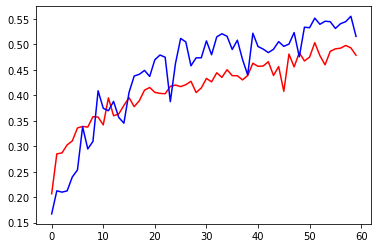

Loss visualization:


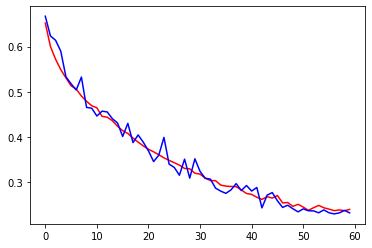

Accuracy visualization:


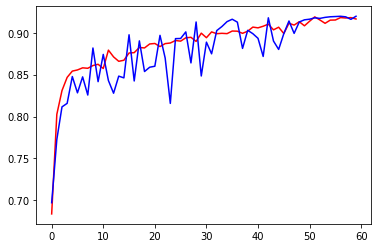

In [ ]:
train_mode = True

criterion = torch.nn.BCELoss()
model = MACUNet(in_ch, out_ch).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

if train_mode == True:
  model = train_model(model, criterion, optimizer, dataloaders, epochs)
else:
  # load best saved checkpoint
  model = torch.load(model_dir + model_file)

# Find the Best Threshold on Validation Set

In [ ]:
from pickle import NONE
# ======================
# Visualize results for val set
# ======================

model.eval()

thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

max_iou = 0.0
chosen_threshold = None

for curr_threshold in thresholds:
    total_iou = 0.0

    for n in range(len(val_dataset)):
        input, output, rgb_path = val_dataset[n]
        x_tensor = torch.from_numpy(input).to(device).unsqueeze(0)
        output = output.squeeze()

        prediction = model(x_tensor)
        prediction = (prediction > curr_threshold).long()
        tensor_output = torch.Tensor(output).view(1, 1, 256, 256).to(device)
        iou = get_IoU(prediction, tensor_output)

        total_iou += iou

    curr_iou = total_iou / len(val_dataset)

    if curr_iou > max_iou:
        max_iou = curr_iou
        chosen_threshold = curr_threshold

print("Max IoU: ", max_iou)
print("Chosen threshold: ", chosen_threshold)
prediction_threshold = chosen_threshold

Max IoU:  tensor(0.5571, device='cuda:0')
Chosen threshold:  0.4


# Visualize Predicted Label Images in Validation Set

In [ ]:
# ======================
# Visualize results for val set
# ======================

model.eval()

for n in range(len(val_dataset)):
    input, output, rgb_path = val_dataset[n]
    x_tensor = torch.from_numpy(input).to(device).unsqueeze(0)
    output = output.squeeze()

    prediction = model(x_tensor)
    prediction = (prediction > prediction_threshold).long().squeeze().cpu().numpy().round()

    rgb = input.transpose(1, 2, 0)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(rgb[:,:,[2,1,0]]/255)
    plt.subplot(1,3,2)
    plt.imshow(prediction)
    plt.subplot(1,3,3)
    plt.imshow(output)
    plt.show()

    rgb_fname = pathlib.Path(rgb_path).stem
    prediction = (prediction*255).astype('uint8')
    prediction = cv2.resize(prediction, (512, 512), interpolation=cv2.INTER_CUBIC)
    # save prediction with the original image size
    # cv2.imwrite(pred_dir + rgb_fname + '.png', prediction)

Output hidden; open in https://colab.research.google.com to view.

# Visualize Predicted Label Images in Test Set

In [ ]:
from glob import glob

x_test_dir = os.path.join(data_dir, 'test_img')
test_files = glob(x_test_dir + '/*.png')

model.eval()

for f in test_files:
    image = cv2.imread(f, cv2.IMREAD_COLOR)
    input = image.transpose(2, 0, 1).astype('float32')
    x_tensor = torch.from_numpy(input).to(device).unsqueeze(0)

    prediction = model(x_tensor)
    prediction = (prediction > prediction_threshold).long().squeeze().cpu().numpy().round()

    rgb = input.transpose(1, 2, 0)

    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(rgb[:,:,[2,1,0]]/255)
    plt.subplot(1,2,2)
    plt.imshow(prediction)
    plt.show()

    rgb_fname = pathlib.Path(f).stem
    prediction = (prediction*255).astype('uint8')
    prediction = cv2.resize(prediction, (512, 512), interpolation=cv2.INTER_CUBIC)

    # save prediction with the original image size
    cv2.imwrite(pred_dir + rgb_fname + '.png', prediction)

Output hidden; open in https://colab.research.google.com to view.